# Assignment 1 - Deep Learning with Keras

This assignment will test you on the following skills: implementing a convolutional neural network in Keras, utilising the Functional Model API, building custom layers and loss functions, and analysing a trained model.

The model you will be building is called a Variational Autoencoder (VAE), a special type of neural network that uses Bayesian Inference to generate synthetic data. As described in the lectures, a VAE compresses a sample input into a low dimensional space (a latent vector). A constraint is applied in the form of a modification to the loss function, which has the effect of forcing the latent vector to look like a standard normal distribution.

This notebook is divided into sections, which you should use to complete the following tasks:

1. Implement a custom layer that performs the "reparameterization trick" described in the lectures.
2. Use the functional model API in keras to create an encoder model and a decoder model, using the specifications provided. Combine these models into the full VAE architecture.
3. Train the model using the celeb_a dataset of celebrity faces.
4. Create plots that demonstrate the ability of the network to reconstruct images, and generate new images.

In addition to submitting your completed notebook, you should write a 1-page report that discusses the results of the model.

In [1]:
#Link to my colab notebook: https://colab.research.google.com/drive/1OMZG7l7nax4qAQLVoPBb2wEhV6vEImvg?usp=sharing

In [ ]:
# Module imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import models, layers, optimizers, losses

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/celeba

In [ ]:
!unzip /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba

Streaming output truncated to the last 5000 lines.
  inflating: /content/celeba/img_align_celeba/img_align_celeba/003938.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._003938.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/025041.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._025041.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/005391.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._005391.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/012835.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._012835.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/023430.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._023430.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/020139.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img

# Task 1 - Reparameterisation layer

In [ ]:
### Create a class called latent_sampling, which subclasses layers.Layer.
### The class should perform the reparameterisation trick in its .call()
### method.
### Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
### epsilon = N(0,1), a unit normal with same dims as mean and variance

# Include the follow two lines in your .call method:
# self.add_loss(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)))
# self.add_metric(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)), name='kl_loss')


In [ ]:
# Latent Sampling Reparameterisation Layer with Super() & Call() method

class latent_sampling (layers.Layer):
    """Reparameterisation of layers"""
    def __init__(self,
               z_mean_img='z_mean',
               z_log_var_img='z_log_var',
               name='latent_sampling',
               **kwargs):
       super(latent_sampling, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        z_mean_img, z_log_var_img = inputs
        batch_img = tf.shape(z_mean_img)[0]
        dimension = tf.shape(z_mean_img)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_img, dimension))
        z_rep=z_mean_img + tf.exp(0.5 * z_log_var_img) * epsilon

        #Appending KLD loss as metric & total loss
        
        self.add_loss(-0.5 * tf.reduce_sum(1 + z_log_var_img - tf.square( z_mean_img) - tf.exp(z_log_var_img)))
        self.add_metric(-0.5 * tf.reduce_sum(1 + z_log_var_img - tf.square( z_mean_img) - tf.exp(z_log_var_img)), name='kl_loss')

        return z_rep


# Task 2 - Model Definitions

*Task 2.1 - Building Encoder*

In [ ]:
### Create the encoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.

# Model: "encoder"
# ____________________________________________________________________________________________________
#  Layer (type)            Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  enc_input (InputLayer)  [(None, 128, 128, 3)]  None
#  enc_conv_1 (Conv2D)     (None, 64, 64, 32)     ReLU        (3,3)        'same'   enc_input
#  enc_conv_2 (Conv2D)     (None, 32, 32, 64)     ReLU        (3,3)        'same'   enc_conv_1
#  enc_conv_3 (Conv2D)     (None, 16, 16, 64)     ReLU        (3,3)        'same'   enc_conv_2    
#  enc_conv_4 (Conv2D)     (None, 8, 8, 64)       ReLU        (3,3)        'same'   enc_conv_3    
#  enc_flat (Flatten)      (None, 4096)           None        None         None     enc_conv_4
#  z_mean (Dense)          (None, 200)            None        None         None     enc_flat                        
#  z_log_var (Dense)       (None, 200)            None        None         None     enc_flat
#  z (latent_sampling)     (None, 200)            None        None         None     (z_mean, z_log_var)


In [ ]:
# Defining encoder input & corresponding shape
enc_input = layers.Input(shape=(128,128,3), dtype='float32', name ='enc_input')

# Creating different encoder convolutional 2D layers
enc_layer1 =layers.Conv2D(32, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="enc_conv_1")(enc_input)
enc_layer2 =layers.Conv2D(64, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="enc_conv_2")(enc_layer1)
enc_layer3 =layers.Conv2D(64, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="enc_conv_3")(enc_layer2)
enc_layer4 =layers.Conv2D(64, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="enc_conv_4")(enc_layer3)

# Flattening the encoder layer
enc_flat = layers.Flatten(name ="enc_flat")(enc_layer4)

# Defining Mean & Variance of the input image for reparameterization funtion
z_mean = layers.Dense(200, activation='relu', name='z_mean')(enc_flat)
z_log_var = layers.Dense(200, activation='relu', name='z_log_var')(enc_flat)

# Calling Reparameterization Funtion to calculate the Z
z = latent_sampling()([z_mean, z_log_var])

# Building Encoder Model using Funtional API
encoder = models.Model(enc_input,[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_conv_1 (Conv2D)            (None, 64, 64, 32)   896         ['enc_input[0][0]']              
                                                                                                  
 enc_conv_2 (Conv2D)            (None, 32, 32, 64)   18496       ['enc_conv_1[0][0]']             
                                                                                                  
 enc_conv_3 (Conv2D)            (None, 16, 16, 64)   36928       ['enc_conv_2[0][0]']       

In [ ]:
# Double checking the Encoder model connection by ploting the model
#tf.keras.utils.plot_model(encoder)

*Task 2.2 - Building Decoder*

In [ ]:
### Create the decoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.

# Model: "decoder"
# ____________________________________________________________________________________________________
#  Layer (type)                   Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  dec_input (InputLayer)         [(None, 200)]          None
#  dec_dense (Dense)              (None, 4096)           ReLU        None         None     dec_input
#  dec_reshape (Reshape)          (None, 8, 8, 64)       None        None         None     dec_dense
#  dec_conv_1 (Conv2DTranspose)   (None, 8, 8, 64)       ReLU        (3,3)        'same'   dec_reshape
#  dec_conv_2 (Conv2DTranspose)   (None, 16, 16, 64)     ReLU        (3,3)        'same'   dec_conv_1
#  dec_conv_3 (Conv2DTranspose)   (None, 32, 32, 64)     ReLU        (3,3)        'same'   dec_conv_2    
#  dec_conv_4 (Conv2DTranspose)   (None, 64, 64, 32)     ReLU        (3,3)        'same'   dec_conv_3    
#  dec_output (Conv2DTranspose)   (None, 128, 128, 3)    ReLU        (3,3)        'same'   dec_conv_4


In [ ]:
# Defining decoder input & corresponding shape
dec_input = layers.Input(shape=(200), dtype='float32')

# Creating dense layer & reshapping to create decoded layers
dense_layer = layers.Dense(4096, activation='relu', name='dec_dense')(dec_input)
dense_reshape = layers.Reshape((8,8,64), name='dec_reshape')(dense_layer)

# Creating different decoder convolutional 2D transpose layers
dec_layer1 = layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu",padding="same", name ="dec_conv_1")(dense_reshape)
dec_layer2 = layers.Conv2DTranspose(64, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="dec_conv_2")(dec_layer1)
dec_layer3 = layers.Conv2DTranspose(64, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="dec_conv_3")(dec_layer2)
dec_layer4 = layers.Conv2DTranspose(32, kernel_size=(3, 3),strides=(2,2), activation="relu",padding="same", name ="dec_conv_4")(dec_layer3)
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=(3, 3),strides=(2,2), activation="relu", padding="same", name ="decoder_outputs")(dec_layer4)

# Building Decoder Model using Funtional API
decoder = models.Model(inputs = dec_input, outputs=decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 dec_dense (Dense)           (None, 4096)              823296    
                                                                 
 dec_reshape (Reshape)       (None, 8, 8, 64)          0         
                                                                 
 dec_conv_1 (Conv2DTranspose  (None, 8, 8, 64)         36928     
 )                                                               
                                                                 
 dec_conv_2 (Conv2DTranspose  (None, 16, 16, 64)       36928     
 )                                                               
                                                                 
 dec_conv_3 (Conv2DTranspose  (None, 32, 32, 64)       3692

In [ ]:
# Double checking the Decoder model connection by ploting the model
#tf.keras.utils.plot_model(decoder)

*Task 2.3 - Creating VAE Model*

In [ ]:
### Create the VAE model, again using tf.keras.models.Model, with the function
### API to combine the feed the outputs of the encoder into the inputs of the
### decoder.

In [ ]:
# Re-initializing Encoder Input
enc_input = layers.Input(shape=(128,128,3), dtype='float32', name ='enc_input')

# Extracting Latent Z information from encoder for feeding to the decoder input to generate output parameter for VAE Model
z_mean_img, z_log_var_img, z_latent = encoder(enc_input)
reconstructed_z = decoder(z_latent)

# Building VAE funtional Model by giving Encoder Input as input & decoder output as output
vae = models.Model(enc_input, reconstructed_z, name ="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 200),             1732048   
                              (None, 200),                       
                              (None, 200)]                       
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       953411    
                                                                 
Total params: 2,685,459
Trainable params: 2,685,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Double checking the VAE model connection by ploting the model
#tf.keras.utils.plot_model(vae)

# Task 3 - Train the model

In [ ]:
# Defining loss functions for the VAE model

def recon_loss(y_true, y_pred):
    recon = tf.reduce_sum(tf.square(y_true-y_pred), axis=(1,2,3))
    return tf.reduce_mean(recon)

*Task 3.1 -Data Pre-Processing*

In [ ]:
# Data Pre-processing section to generate Train,Valid & Test Dataset from CelebA dataset

import pathlib
data_dir = pathlib.Path('/content/celeba/img_align_celeba')
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [128, 128])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.cast(img, 'float32')/255.
  return img, img

proc_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Extracting Train,Valid & Test Image Dataset
train_ds = proc_ds.take(20000).cache().batch(64, drop_remainder=True)
valid_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)
test_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)

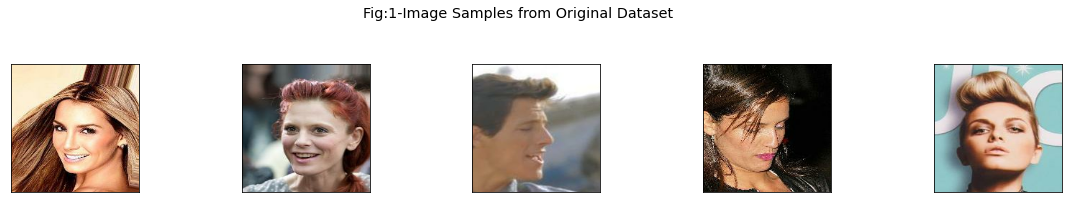

In [ ]:
# Ploting few sample images from Origianl dataset to ensure the dataset extraction for train,test & validation
# Defining the Plot size,Title & Color properties
plt.figure(figsize=(20, 8))
plt.suptitle("Fig:1-Image Samples from Original Dataset", fontsize="x-large",color='black')
#plt.rcParams['axes.facecolor'] = 'black'

# Unbatching tuple image files for displaying
sample_img = train_ds.unbatch().take(5)
sample_img = [image for image in sample_img]

for i in range(5):
    # display original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(sample_img[i][0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

*Task 3.2 -Compile Model & Finding Best Learning Rate*

In [ ]:
### Compile the VAE model, choosing an appropriate optimizer and learning rate,
### the total_loss function as the model loss, and any appropriate metrics.
### Train the model using the train dataset for an appropriate number of epochs.
### Store the losses and metrics in the history dictionary.

*Task 3.2.1 -Compile Model using Learning Rate=* **0.00005**

In [ ]:
#Combile VAE model with Adam optimizer @ Learning Rate 0.000005

vae.compile(optimizer=optimizers.Adam(learning_rate=0.000005),loss=recon_loss,metrics=['accuracy'])

#Training the VAE model & Storing all the metrics to a history dictionary
metrics_history2=vae.fit(train_ds,validation_data=valid_ds,epochs=20, batch_size=64,verbose=1)

Epoch 1/20
312/312 [==============================] - 47s 120ms/step - loss: 13505.3555 - accuracy: 0.3985 - kl_loss: 2.2482 - val_loss: 13177.2607 - val_accuracy: 0.4131 - val_kl_loss: 2.8520
Epoch 2/20
312/312 [==============================] - 36s 117ms/step - loss: 11840.4414 - accuracy: 0.4170 - kl_loss: 46.6879 - val_loss: 9920.3154 - val_accuracy: 0.4211 - val_kl_loss: 121.0921
Epoch 3/20
312/312 [==============================] - 35s 111ms/step - loss: 8538.2891 - accuracy: 0.4357 - kl_loss: 109.3412 - val_loss: 7580.0825 - val_accuracy: 0.4590 - val_kl_loss: 113.5337
Epoch 4/20
312/312 [==============================] - 37s 119ms/step - loss: 6970.1963 - accuracy: 0.4760 - kl_loss: 154.4800 - val_loss: 6460.2607 - val_accuracy: 0.4882 - val_kl_loss: 182.8365
Epoch 5/20
312/312 [==============================] - 40s 128ms/step - loss: 6032.8228 - accuracy: 0.5144 - kl_loss: 236.9837 - val_loss: 5637.5645 - val_accuracy: 0.5289 - val_kl_loss: 259.3243
Epoch 6/20
312/312 [=======

*Task 3.2.2 -Compile Model using Learning Rate=* **0.001**

In [ ]:
#Combile VAE model with Adam optimizer @ Learning Rate 0.001
vae.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=recon_loss,metrics=['accuracy'])

#Training the VAE model & Storing all the metrics to a history dictionary
metrics_history3=vae.fit(train_ds,validation_data=valid_ds,epochs=20, batch_size=64,verbose=1)

Epoch 1/20
312/312 [==============================] - 34s 106ms/step - loss: 3896.1758 - accuracy: 0.6985 - kl_loss: 261.9810 - val_loss: 3156.8855 - val_accuracy: 0.7281 - val_kl_loss: 299.0913
Epoch 2/20
312/312 [==============================] - 34s 108ms/step - loss: 3052.1060 - accuracy: 0.7242 - kl_loss: 358.4110 - val_loss: 2987.9221 - val_accuracy: 0.7193 - val_kl_loss: 346.3981
Epoch 3/20
312/312 [==============================] - 34s 108ms/step - loss: 2962.6357 - accuracy: 0.7223 - kl_loss: 383.6475 - val_loss: 2916.1179 - val_accuracy: 0.7076 - val_kl_loss: 382.9590
Epoch 4/20
312/312 [==============================] - 33s 104ms/step - loss: 2911.8047 - accuracy: 0.7223 - kl_loss: 395.2495 - val_loss: 2897.5054 - val_accuracy: 0.7102 - val_kl_loss: 421.5172
Epoch 5/20
312/312 [==============================] - 34s 108ms/step - loss: 2879.5701 - accuracy: 0.7224 - kl_loss: 402.1654 - val_loss: 2876.9070 - val_accuracy: 0.7058 - val_kl_loss: 432.9220
Epoch 6/20
312/312 [=====

*Task 3.2.3 -Compile Model using Learning Rate=* **0.00001**

In [ ]:
#Combile VAE model with Adam optimizer @ Learning Rate 0.00001
vae.compile(optimizer=optimizers.Adam(learning_rate=0.00001),loss=recon_loss,metrics=['accuracy'])

#Training the VAE model & Storing all the metrics to a history dictionary
metrics_history4=vae.fit(train_ds,validation_data=valid_ds,epochs=20, batch_size=64,verbose=1)

Epoch 1/20
312/312 [==============================] - 35s 109ms/step - loss: 12706.8906 - accuracy: 0.3218 - kl_loss: 23.2402 - val_loss: 9892.7520 - val_accuracy: 0.3316 - val_kl_loss: 113.0392
Epoch 2/20
312/312 [==============================] - 34s 108ms/step - loss: 7838.5835 - accuracy: 0.3789 - kl_loss: 117.3339 - val_loss: 6411.9434 - val_accuracy: 0.4435 - val_kl_loss: 195.2810
Epoch 3/20
312/312 [==============================] - 34s 109ms/step - loss: 5389.7866 - accuracy: 0.5187 - kl_loss: 282.0938 - val_loss: 4606.0981 - val_accuracy: 0.5886 - val_kl_loss: 318.1398
Epoch 4/20
312/312 [==============================] - 33s 105ms/step - loss: 4245.9946 - accuracy: 0.6462 - kl_loss: 331.2400 - val_loss: 3989.2888 - val_accuracy: 0.6852 - val_kl_loss: 339.1659
Epoch 5/20
312/312 [==============================] - 33s 105ms/step - loss: 3832.7131 - accuracy: 0.6995 - kl_loss: 339.3526 - val_loss: 3710.8818 - val_accuracy: 0.7055 - val_kl_loss: 332.1684
Epoch 6/20
312/312 [=====

*Task 3.2.4 -Compile Model using Learning Rate=* **0.0005**

In [ ]:
#Combile VAE model with Adam optimizer @ Learning Rate 0.0005
vae.compile(optimizer=optimizers.Adam(learning_rate=0.0005),loss=recon_loss,metrics=['accuracy'])

metrics_history=vae.fit(train_ds,validation_data=valid_ds,epochs=20, batch_size=64,verbose=1)

Epoch 1/20
312/312 [==============================] - 35s 110ms/step - loss: 4177.6187 - accuracy: 0.6675 - kl_loss: 263.6089 - val_loss: 3152.6658 - val_accuracy: 0.7275 - val_kl_loss: 408.3282
Epoch 2/20
312/312 [==============================] - 34s 110ms/step - loss: 3092.0686 - accuracy: 0.7295 - kl_loss: 393.3816 - val_loss: 3051.4036 - val_accuracy: 0.7272 - val_kl_loss: 406.2631
Epoch 3/20
312/312 [==============================] - 36s 114ms/step - loss: 2973.1267 - accuracy: 0.7243 - kl_loss: 416.5997 - val_loss: 2936.4326 - val_accuracy: 0.7139 - val_kl_loss: 427.6812
Epoch 4/20
312/312 [==============================] - 34s 110ms/step - loss: 2925.5586 - accuracy: 0.7227 - kl_loss: 426.3306 - val_loss: 2875.9717 - val_accuracy: 0.7160 - val_kl_loss: 428.8795
Epoch 5/20
312/312 [==============================] - 34s 109ms/step - loss: 2880.1418 - accuracy: 0.7236 - kl_loss: 433.4720 - val_loss: 2869.6626 - val_accuracy: 0.7191 - val_kl_loss: 410.4684
Epoch 6/20
312/312 [=====

*Task 3.2.5 -Best Learning Rate Plot*

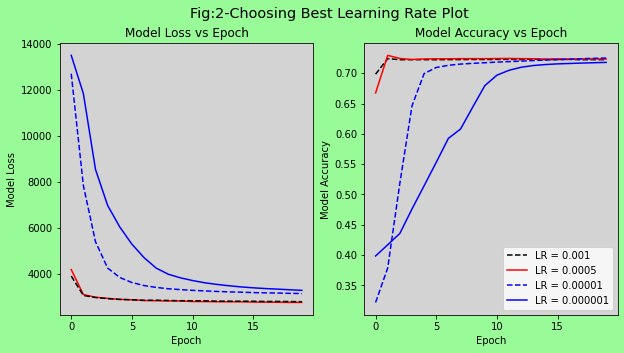

In [ ]:
# Plot created for model with different learning rate

# Defining plot with figure size,background color & plot title
f, ax = plt.subplots(1,2, figsize=(10,5))
f.patch.set_facecolor('palegreen')
f.suptitle("Fig:2-Choosing Best Learning Rate Plot", fontsize="x-large")

# Ploting obtained loss metrics from model training with different learning rate
ax[0].plot(metrics_history2.history['loss'], c='b')
ax[0].plot(metrics_history.history['loss'], c='r')
ax[0].plot(metrics_history3.history['loss'], c='k', ls='--')
ax[0].plot(metrics_history4.history['loss'], c='b', ls='--')

# Setting axis,labels & plot color
ax[0].set_ylabel('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title ('Model Loss vs Epoch')
ax[0].set_facecolor("lightgrey")

# Ploting obtained accuracy metrics from model training with different learning rate
ax[1].plot(metrics_history3.history['accuracy'], label='LR = 0.001', c='k', ls='--')
ax[1].plot(metrics_history.history['accuracy'], label='LR = 0.0005', c='r')
ax[1].plot(metrics_history4.history['accuracy'], label='LR = 0.00001', c='b', ls='--')
ax[1].plot(metrics_history2.history['accuracy'], label='LR = 0.000001', c='b')

# Setting axis,labels & plot color
ax[1].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title ('Model Accuracy vs Epoch')
ax[1].set_facecolor("lightgrey")

plt.legend()

*Task 3.2.6 -* **Conclusion on Best Learning Rate for VAE**


*   Best Learning Rate for the Optimizer is 0.0005 with a good accuracy & convergence
*   If we apply Learning rate 0.01 or above, the Model goes in to local minimas & the learning is immediately stopped



# Task 4 - Analyse the Model

In [ ]:
### Plot the losses and metrics. Comment on the figures in your report, with
### regard to how the training has proceeded.

In [ ]:
# Checking the common keys on the metrics history
metrics_history.history.keys()

dict_keys(['loss', 'accuracy', 'kl_loss', 'val_loss', 'val_accuracy', 'val_kl_loss'])

*Task 4.1 -Plotting Losses & Metrics with Selected Learning rate & model*

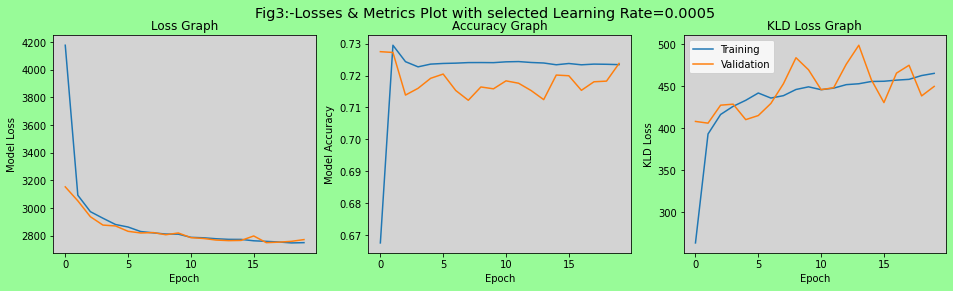

In [ ]:
# Plot the losses and metrics for the training and test data
# Defining plot with figure size,background color & plot title
f, ax = plt.subplots(1,3, figsize=(16,4))
f.suptitle("Fig3:-Losses & Metrics Plot with selected Learning Rate=0.0005", fontsize="x-large")
f.patch.set_facecolor('palegreen')

# Ploting obtained loss metrics from model training
ax[0].plot(metrics_history.history['loss'], label='Training')
ax[0].plot(metrics_history.history['val_loss'], label='Validation')

# Setting axis,labels & plot color
ax[0].set_ylabel('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_facecolor("lightgrey")
ax[0].set_title ('Loss Graph')

# Ploting obtained loss metrics from model training
ax[1].plot(metrics_history.history['accuracy'], label='Training')
ax[1].plot(metrics_history.history['val_accuracy'], label='Validation')

# Setting axis,labels & plot color
ax[1].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_facecolor("lightgrey")
ax[1].set_title ('Accuracy Graph')

# Ploting obtained loss metrics from model training
ax[2].plot(metrics_history.history['kl_loss'], label='Training')
ax[2].plot(metrics_history.history['val_kl_loss'], label='Validation')

# Setting axis,labels & plot color
ax[2].set_ylabel('KLD Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_facecolor("lightgrey")
ax[2].set_title ('KLD Loss Graph')

plt.legend()

*Task 4.2 -Model Evaluvation Using Test data*

In [ ]:
# Evaluating the model performance on the test data set

test_loss_result = vae.evaluate(test_ds,return_dict=True)
test_loss = test_loss_result['loss']
print("Loss from Model Evaluvation using Test Data : {}".format(test_loss))

156/156 [==============================] - 10s 67ms/step - loss: 2763.5925 - accuracy: 0.7234 - kl_loss: 450.0424
Loss from Model Evaluvation using Test Data : 2763.592529296875


*Task 4.3 -* **Model Image Reconstruction Section & Plot**

In [ ]:
### Using the test dataset, create a plot that shows the reconstruction quality
### of the training model. Comment on the results in your report.

In [ ]:
#Reconstructing the image using the trained VAE model by providing test dataset as input
predicted_img=vae.predict(test_ds)

156/156 [==============================] - 10s 60ms/step


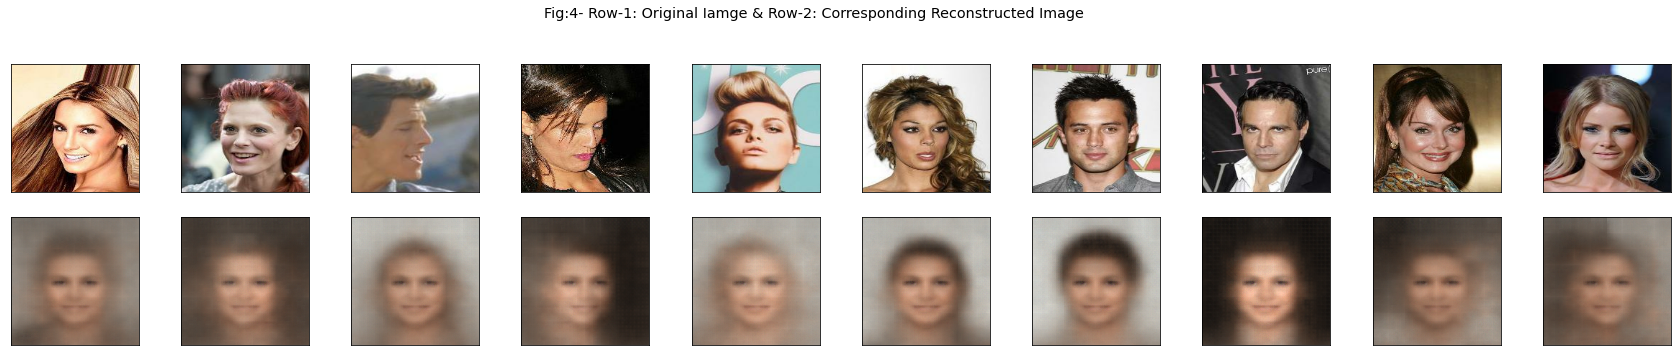

In [ ]:
# Ploting the Original & Reconstructed Image
# Defining plot with figure size,background color & plot title
n = 10  
plt.figure(figsize=(30, 8))
#plt.rcParams['axes.facecolor'] = 'black'
plt.suptitle("Fig:4- Row-1: Original Iamge & Row-2: Corresponding Reconstructed Image", fontsize="x-large",color='black')

# Unbactching the tuple image dataset for the correct ploting format
test_ds1 = test_ds.unbatch().take(25)
test_ds1 = [image for image in test_ds1]

# Iterating over both original & VAE model reconstructed images
for i in range(n):
    # display original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_ds1[i][0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display vae reconstruction image
    ax = plt.subplot(3, n, i + 1 + 1*n)
    plt.imshow(predicted_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

*Task 4.4 -* **VAE Image Generation from Random Latent Vector Samples**

In [ ]:
### Demonstrate the generative properties of the VAE by drawing randomly sampled
### latent vectors from a unit Guassian and passing them to the train decoder.
### Plot the results and comment on them in your report.

In [ ]:
# Creating 20 random sample latent vector with size 200 for passing to the trained decoder input
latent_vectors = np.random.normal(0,1,(20,200))

# Random Latent vectors are feeded to trained decoder to generate images
generated_images = decoder.predict(latent_vectors)

# generated images multiplied to the color pattern
generated_images = generated_images * 255
generated_images = generated_images.astype('uint8')

1/1 [==============================] - 0s 223ms/step


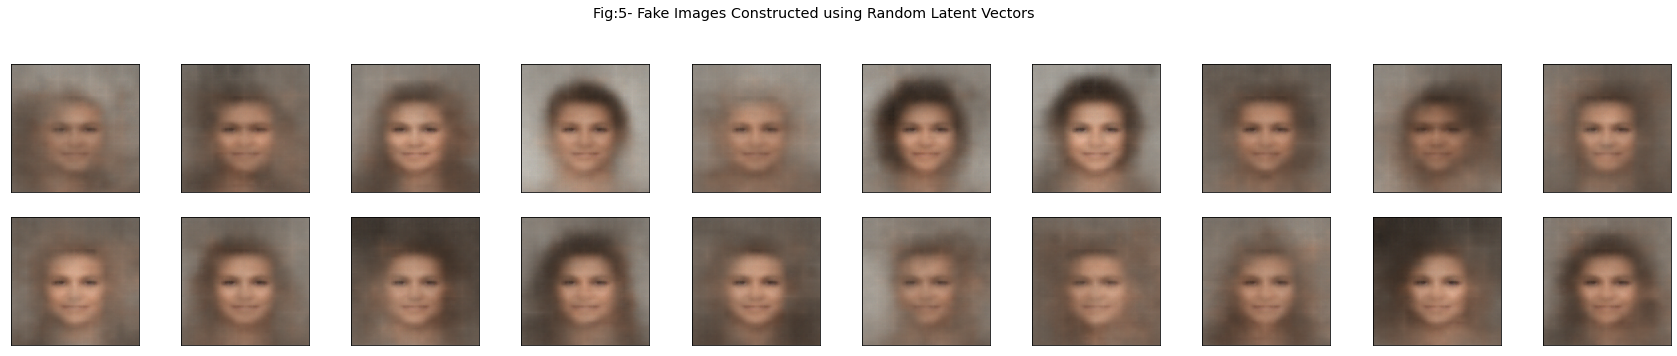

In [ ]:
# Plot the fake images created by the decoder
# Defining plot with figure size,background color & plot title
plt.figure(figsize=(30, 8))
#plt.rcParams['axes.facecolor'] = 'black'
plt.suptitle("Fig:5- Fake Images Constructed using Random Latent Vectors", fontsize="x-large",color='black')

# Iterating over the generated image to print one by one
n=10
for i in range(20):
    # display constructed images from random latent vector
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(generated_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)